# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Section 1: Preparing the vocabulary

In [22]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [23]:
#read file and create a list from data
words_array = np.genfromtxt('wordlist.txt', dtype=str) 
words_list = list(words_array)

#extract words longer than 3 letters and maximum length WORD_SIZE
extracted_list = [word.lower() for word in words_list if 3<len(word)<=WORD_SIZE]

#make data fixed length
vocab = [word.ljust(WORD_SIZE,'_') for word in extracted_list]


#display results
print('number of total data samples = ',len(words_array))
print('first 5 data: \n',words_list[:5])
print('-'*50)

print('\nextracted word list size = ', len( extracted_list))
print('first 5 data: \n',extracted_list[:5])
print('-'*50)

print('\nword length adjusted array\'s 5 data samples: \n',vocab[:5])
print('length of a word = ', len(vocab[1]))


number of total data samples =  10000
first 5 data: 
 ['a', 'aa', 'aaa', 'aaron', 'ab']
--------------------------------------------------

extracted word list size =  8847
first 5 data: 
 ['aaron', 'abandoned', 'aberdeen', 'abilities', 'ability']
--------------------------------------------------

word length adjusted array's 5 data samples: 
 ['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______']
length of a word =  13


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

* shorter words (size less than 3 letters) might not provide enough meaningful context for training a ML model.
* extremely longer words might slow down the training, and will require hgh computational and memory resources
* longer words require higher sequence length for RNN, and this can result in exploiding  or vanishing gradients as well as increase model complexity
* Selecting words within a specific length range would help generalization of the model without biasing towards the two extremities.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [24]:
#converts a character to a number (Encoding)
def char_to_num(char):
    '''
    ASCII values for, 'a' = 97 and 'z' = 122
    num = ASCII - 96
    '''
    
    if char == '_':
        num = 0
    else:
        ascii_id = ord(char) # get the ASCII code of the character

        if 97 <= ascii_id <= 122:
            num = ord(char) - 96 #comput ID with the use of its ASCII code
        else:
            print('invalid input')   
    return(num)



#convert a number to a character (Deciding)
def num_to_char(num):
    if num<0 or num>26:
        print('Invalid input. Enter a number between [0,26].')
    elif num==0:
        char = '_'
    else:
        ascii_id = num + 96
        char = chr(ascii_id)
    
    return(char)


#Encode a word
def word_to_numlist(word):
    '''
    input  : word- a string of characterd from a-z
    output : numlist -a pytorch tensor of encoded result with shape , (1,N) where N = len(word)
    '''

    char_list = list(word)
    numlist = [char_to_num(i) for i in char_list]
    
    numlist = torch.tensor(numlist).reshape(1,-1)

    return(numlist)


#Decode a tensor of numbers
def numlist_to_word(numlist):
    '''
    input  : numlist- a pytorch tensor of shape (1,N)
    output : word - a string, the decoded result
    '''

    temp = torch.squeeze(numlist)
    word=''
    for i in range (len(temp)):
        num = temp[i]
        word += num_to_char(num)
    return(word)


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

* Converting letters to numbers based on their alphabetical order is not a good encoding mechanism. The reason is it imposes an ordinal relationship between letters. (e.g. 'a' being closer to 'b' than 'z'). Letters should be treated as categorial data where each one is independent, and no inherent order exists. The numerical method used above can lead to poor model performance as it can confuse the model about relationship between characters.

* This issue is addressed by embedding layers by learning dense, continuous vector representations for each letter while capturing meaningful high dimensional space. The purpose of an embedding layer is to transform sparse categorial inputs like letters into more informative numerical representations that help the model learn better features.


## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [25]:
LEARNING_RATE = 0.005

In [26]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        #Set the input parameters to self parameters

        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation

        self.embedding = nn.Embedding(self.alphabet_size, self.embed_dim)
        self.lstm = nn.LSTM(self.embed_dim , self.hidden_size, self.num_layers)
        self.fc = nn.Linear(self.hidden_size, self.alphabet_size)



    #Feedforward
    def forward(self, character, hidden_state, cell_state):

        #Perform feedforward in order
        #1. Embed the input (one charcter represented by a number)
        #2. Feed the embedded output to the LSTM cell
        #3. Feed the LSTM output to the fully connected layer to obtain the output
        #4. return the output, and both the hidden state and cell state from the LSTM cell output

        x = self.embedding(character)
        x, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state))
        output = self.fc(x)

        return output, hidden_state, cell_state



    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self): 
        h0 = torch.zeros((self.num_layers, self.hidden_size))
        c0 = torch.zeros((self.num_layers, self.hidden_size))
        return (h0, c0)


    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 100):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters  and learning rate
        optimizer = torch.optim.Adam(self.parameters(), lr = LEARNING_RATE)

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        #calculate numberof iterations to go through the entire dataset
        num_iter = int(np.ceil(len(vocab)/batch_size))
        
        #initialize the loss function
        criterion = nn.CrossEntropyLoss()

        for e in range(epochs):

            #Shuffle the vocab list the start of each epoch
            random.shuffle(vocab)

            for i in range(num_iter):

                #get the data batch
                try:
                    vocab_batch = vocab[i*batch_size:(i+1)*batch_size]
                except: 
                    vocab_batch = vocab[i*batch_size:]

                # Set the loss to zero, initialize the optimizer with zero_grad at the beginning of each training cycle.
                loss = 0
                optimizer.zero_grad()

                for word in vocab_batch:
                    # Initialize the hidden state and cell state at the start of each word.
                    hidden_state, cell_state = self.initial_state() 

                    # Convert the word into a tensor of number and create input and target from the word
                    #Input will be the first WORD_SIZE - 1 charcters and target is the last WORD_SIZE - 1 charcters

                    num_list = word_to_numlist(word)
                    
                    x_input = num_list[ :, : WORD_SIZE - 1]#.reshape(1,-1)
                    y_true = num_list[ :, -WORD_SIZE+1 : ]#.reshape(1,-1)

                    #Loop through each character (as a number) in the word
                    for c in range(WORD_SIZE - 1):
                        # Feed the cth character to the model (feedforward) and comput the loss (use cross entropy in torch)
                        y_pred, hidden_state, cell_state = self.forward(x_input[:,c], hidden_state, cell_state)
                        
                        loss += criterion(y_pred, y_true[:,c])

                # Compute the average loss per word in the batch and perform backpropagation (.backward())
                loss /= len(vocab_batch)
                loss.backward()
                    
                # Update model parameters using the optimizer
                optimizer.step()

                #Update the loss_log 
                loss_log.append(loss.item())

            print(f'Epoch {e+1}|{epochs} ============> train loss:  {loss.item():.4f}')


        #Plot a graph of the variation of the loss.
        locs = np.arange(0, len(loss_log)+1, num_iter)
        labels = np.arange(0, epochs+1, 1)

        plt.figure(figsize=(6,4))
        plt.plot(loss_log, c='darkcyan')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.xticks(locs, labels)
        plt.title('Loss Variation')
        plt.show()


    #Perform autocmplete
    # given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample):

        #Convert the model into evaluation mode
        self.eval()

        # In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        #You will have to convert the output into a softmax (you may use your softmax method from the last project) probability distribution, then use torch.multinomial

        completed_list = []

        #take word by word from the sample
        for literal in sample:
            hidden_state, cell_state = self.initial_state() # initialize hidden state and cell state
            
            num_list = word_to_numlist(literal) # encode the literal
            
            predicted_word = literal

            # compute the hidden state and cell state inputs to the model based on input data
            for i in range(len(literal)-1):
                x_input = num_list[:,i]
                _, hidden_state, cell_state = self.forward(x_input, hidden_state, cell_state)
            
            # input number to the model (encoded result of the last character of the literal)
            x_input = num_list[:,-1]

            for i in range (WORD_SIZE - len(literal)):
                # forward pass
                char_pred, hidden_state, cell_state = self.forward(x_input, hidden_state, cell_state)

                # Convert to softmax probabilities
                char_prob = nn.functional.softmax(char_pred, dim=-1)
                
                # Sample from the probability distribution
                next_char_idx = torch.multinomial(char_prob, 1).item()

                #construct the word 
                predicted_word += num_to_char(next_char_idx)

                #next input to the model
                num_list = torch.concat((num_list, torch.tensor([[next_char_idx]])), dim=1)
                x_input = num_list[:,-1]

            # store predicted words
            completed_list.append(predicted_word)

        return(completed_list)

    

## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

The best performance was obtained for the following parameter combinations.
* embed_dim=32
* hidden_size=128
* learning rate = 0.05
* batch size = 100 

Training error can be further reduced by training longor (for more epochs) carefully looking for overfitting. However the model has a long execution time making it difficult to achieve very good results in a limited computational resource setting.

The training seems successful.

Model outputs often result in parts like 'tion' , 'ing', 'ly' probably due to its training dataset contained higher number of data samples with that format (imbalanced train dataset). This can be avoided by having a balanced dataset.

To improve the model, adding more data or data augmentation for better generalization,  adding regularization, increasing rnn layers, using more advanced and generalized encoding technique can be done.

Epoch 1|5 ============> train loss:  20.4718
Epoch 2|5 ============> train loss:  18.4428
Epoch 3|5 ============> train loss:  17.2962
Epoch 4|5 ============> train loss:  16.9577
Epoch 5|5 ============> train loss:  15.3547


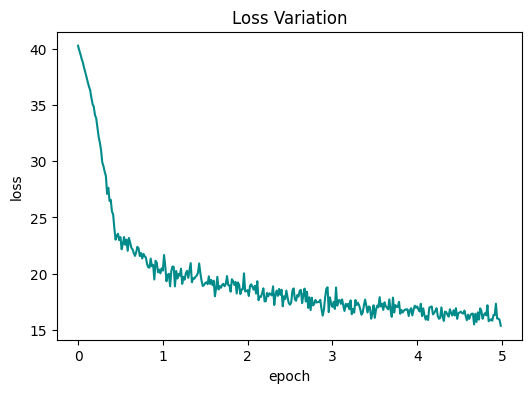

['univeratied__', 'matha________', 'neurnem______', 'enginar______']


In [27]:
LEARNING_RATE = 0.001

#initialize the autocompleteModel
model = autocompleteModel(alphabet_size=27, embed_dim=30, hidden_size=64, num_layers=1)

#train the model
model.trainModel(vocab, epochs = 5, batch_size = 128)

#evaluate the model
sample=['univ', 'math', 'neur', 'engin']
completed_list = model.autocomplete(sample)
print(completed_list)

Epoch 1|5 ============> train loss:  21.7748
Epoch 2|5 ============> train loss:  18.1549
Epoch 3|5 ============> train loss:  19.3112
Epoch 4|5 ============> train loss:  17.0369
Epoch 5|5 ============> train loss:  16.0819


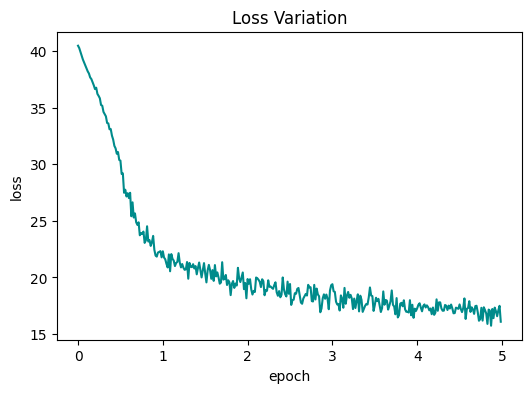

result:  ['unive________', 'mathudla_____', 'neurul_______', 'enginatne____']


In [28]:
LEARNING_RATE = 0.001

#initialize the autocompleteModel
model = autocompleteModel(alphabet_size=27, embed_dim=32, hidden_size=32, num_layers=1)

#train the model
model.trainModel(vocab, epochs = 5, batch_size = 128)

#evaluate the model
sample=['univ', 'math', 'neur', 'engin']
completed_list = model.autocomplete(sample)
print('result: ', completed_list)

Epoch 1|5 ============> train loss:  16.7179
Epoch 2|5 ============> train loss:  14.9793
Epoch 3|5 ============> train loss:  15.2409
Epoch 4|5 ============> train loss:  14.1130
Epoch 5|5 ============> train loss:  13.3803


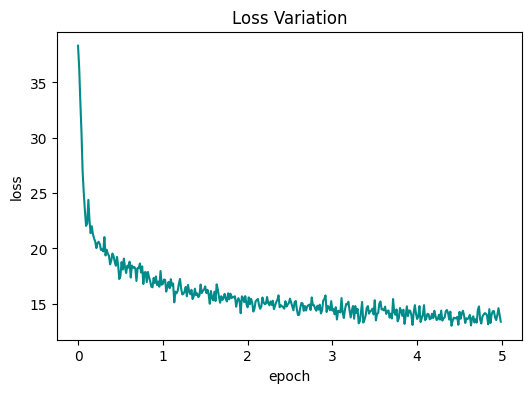

result:  ['univericy____', 'mathict______', 'neuraning____', 'engine_______']


In [29]:
LEARNING_RATE = 0.005

#initialize the autocompleteModel
model = autocompleteModel(alphabet_size=27, embed_dim=32, hidden_size=64, num_layers=1)

#train the model
model.trainModel(vocab, epochs = 5, batch_size = 120)

#evaluate the model
sample=['univ', 'math', 'neur', 'engin']
completed_list = model.autocomplete(sample)
print('result: ', completed_list)

Epoch 1|5 ============> train loss:  14.6721
Epoch 2|5 ============> train loss:  13.6651
Epoch 3|5 ============> train loss:  13.9867
Epoch 4|5 ============> train loss:  13.3567
Epoch 5|5 ============> train loss:  13.1530


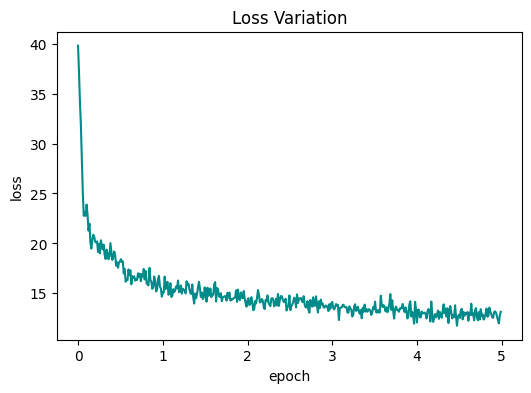

result:  ['universe_____', 'mathh________', 'neur_________', 'enginding____']


In [30]:
LEARNING_RATE = 0.004

#initialize the autocompleteModel
model = autocompleteModel(alphabet_size=27, embed_dim=32, hidden_size=128, num_layers=1)

#train the model
model.trainModel(vocab, epochs = 5, batch_size = 100)

#evaluate the model
sample=['univ', 'math', 'neur', 'engin']
completed_list = model.autocomplete(sample)
print('result: ', completed_list)

In [31]:
sample=['flow', 'fath', 'wall', 'hac', 'run', 'hun', 'drin', 'co', 'ver']
completed_list = model.autocomplete(sample)
print(completed_list)

['flowels______', 'fath_________', 'walledce_____', 'hacked_______', 'runk_________', 'hund_________', 'drin_________', 'cost_________', 'verimined____']


Epoch 1|5 ============> train loss:  16.4534
Epoch 2|5 ============> train loss:  13.6375
Epoch 3|5 ============> train loss:  13.1486
Epoch 4|5 ============> train loss:  12.8994
Epoch 5|5 ============> train loss:  12.2774


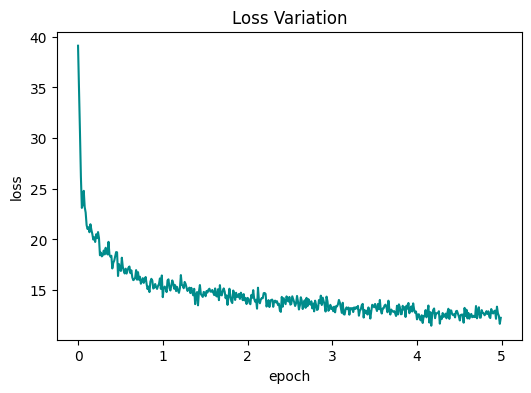

result:  ['univelarded__', 'mathargary___', 'neurels______', 'enginan______']


In [32]:
LEARNING_RATE = 0.005

#initialize the autocompleteModel
model = autocompleteModel(alphabet_size=27, embed_dim=32, hidden_size=128, num_layers=1)

#train the model
model.trainModel(vocab, epochs = 5, batch_size = 100)

#evaluate the model
sample=['univ', 'math', 'neur', 'engin']
completed_list = model.autocomplete(sample)
print('result: ', completed_list)

In [33]:
sample=['flow', 'fath', 'wall', 'hac', 'run', 'hun', 'drin', 'co', 'ver']
completed_list = model.autocomplete(sample)
print(completed_list)

['flowallgeng__', 'fath_________', 'walls________', 'hacting______', 'runk_________', 'hung_________', 'dringhe______', 'convemped____', 'veror________']


Epoch 1|25 ============> train loss:  16.5800
Epoch 2|25 ============> train loss:  14.1784
Epoch 3|25 ============> train loss:  13.4684
Epoch 4|25 ============> train loss:  14.0234
Epoch 5|25 ============> train loss:  12.7940
Epoch 6|25 ============> train loss:  11.0841
Epoch 7|25 ============> train loss:  11.3596
Epoch 8|25 ============> train loss:  11.7682
Epoch 9|25 ============> train loss:  11.3825
Epoch 10|25 ============> train loss:  11.1994
Epoch 11|25 ============> train loss:  11.2479
Epoch 12|25 ============> train loss:  10.7093
Epoch 13|25 ============> train loss:  10.2347
Epoch 14|25 ============> train loss:  9.9652
Epoch 15|25 ============> train loss:  10.0974
Epoch 16|25 ============> train loss:  9.9367
Epoch 17|25 ============> train loss:  9.1784
Epoch 18|25 ============> train loss:  9.2708
Epoch 19|25 ============> train loss:  9.5268
Epoch 20|25 ============> train loss:  9.1772
Epoch 21|25 ============> train loss:  8.7695
Epoch 22|25 ============> tra

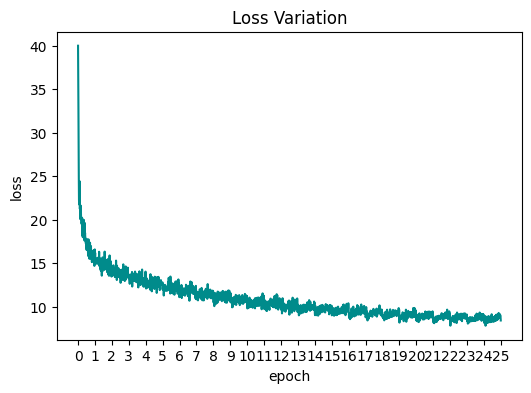

result:  ['univering____', 'mathemative__', 'neural_______', 'engineet_____']


In [34]:
LEARNING_RATE = 0.005

#initialize the autocompleteModel
model = autocompleteModel(alphabet_size=27, embed_dim=32, hidden_size=128, num_layers=1)

#train the model
model.trainModel(vocab, epochs = 25, batch_size = 100)

#evaluate the model
sample=['univ', 'math', 'neur', 'engin']
completed_list = model.autocomplete(sample)
print('result: ', completed_list)

In [35]:
sample=['flow', 'fath', 'wall', 'hac', 'run', 'hun', 'drin', 'co', 'ver']
completed_list = model.autocomplete(sample)
print(completed_list)

['flowar_______', 'father_______', 'wallet_______', 'hach_________', 'runns________', 'hundred______', 'drinks_______', 'committed____', 'verify_______']


Epoch 1|25 ============> train loss:  15.7809
Epoch 2|25 ============> train loss:  13.9002
Epoch 3|25 ============> train loss:  14.0881
Epoch 4|25 ============> train loss:  12.4797
Epoch 5|25 ============> train loss:  12.5088
Epoch 6|25 ============> train loss:  13.3536
Epoch 7|25 ============> train loss:  11.7010
Epoch 8|25 ============> train loss:  11.9905
Epoch 9|25 ============> train loss:  12.5892
Epoch 10|25 ============> train loss:  10.9365
Epoch 11|25 ============> train loss:  12.8263
Epoch 12|25 ============> train loss:  12.2222
Epoch 13|25 ============> train loss:  12.1881
Epoch 14|25 ============> train loss:  12.1912
Epoch 15|25 ============> train loss:  11.7120
Epoch 16|25 ============> train loss:  11.3219
Epoch 17|25 ============> train loss:  11.7418
Epoch 18|25 ============> train loss:  11.2488
Epoch 19|25 ============> train loss:  12.4750
Epoch 20|25 ============> train loss:  11.3374
Epoch 21|25 ============> train loss:  11.5896
Epoch 22|25 ==========

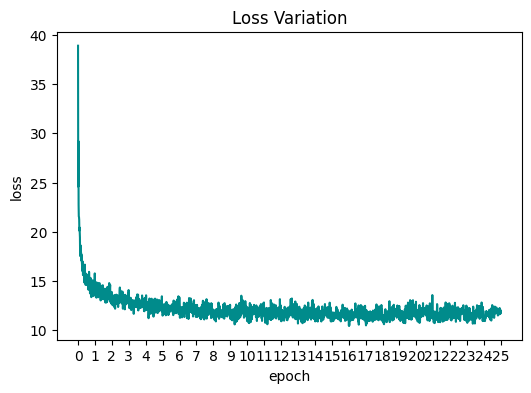

['univericalle_', 'matha________', 'neuran_______', 'enginarislia_']


In [36]:
LEARNING_RATE = 0.04

#initialize the autocompleteModel
model = autocompleteModel(alphabet_size=27, embed_dim=32, hidden_size=128, num_layers=1)

#train the model
model.trainModel(vocab, epochs = 25, batch_size = 100)

#evaluate the model
sample=['univ', 'math', 'neur', 'engin']
completed_list = model.autocomplete(sample)
print(completed_list)

In [37]:
sample=['flow', 'fath', 'wall', 'hac', 'run', 'hun', 'drin', 'co', 'ver']
completed_list = model.autocomplete(sample)
print(completed_list)

['floweld______', 'fathing______', 'wallshopal___', 'hachont______', 'rundo________', 'huntences____', 'drinkine_____', 'comunically__', 'vervelor_____']


Epoch 1|25 ============> train loss:  15.0661
Epoch 2|25 ============> train loss:  13.4892
Epoch 3|25 ============> train loss:  12.9135
Epoch 4|25 ============> train loss:  12.7361
Epoch 5|25 ============> train loss:  12.4867
Epoch 6|25 ============> train loss:  10.6698
Epoch 7|25 ============> train loss:  10.3034
Epoch 8|25 ============> train loss:  11.1509
Epoch 9|25 ============> train loss:  9.8827
Epoch 10|25 ============> train loss:  12.1007
Epoch 11|25 ============> train loss:  9.7588
Epoch 12|25 ============> train loss:  9.7855
Epoch 13|25 ============> train loss:  9.7771
Epoch 14|25 ============> train loss:  9.7816
Epoch 15|25 ============> train loss:  9.6450
Epoch 16|25 ============> train loss:  9.5995
Epoch 17|25 ============> train loss:  9.7016
Epoch 18|25 ============> train loss:  9.0099
Epoch 19|25 ============> train loss:  9.4187
Epoch 20|25 ============> train loss:  9.4098
Epoch 21|25 ============> train loss:  8.6252
Epoch 22|25 ============> train lo

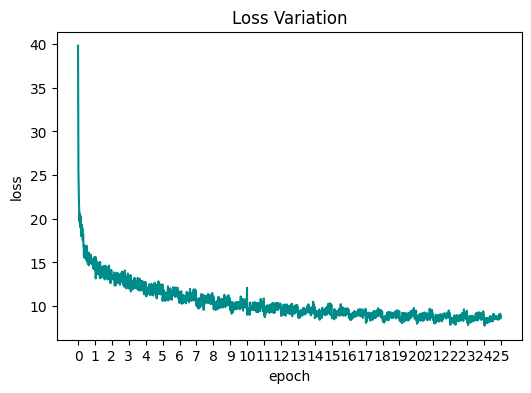

['universali___', 'mathern______', 'neural_______', 'engine_______']


In [38]:
LEARNING_RATE = 0.01

#initialize the autocompleteModel
model = autocompleteModel(alphabet_size=27, embed_dim=32, hidden_size=128, num_layers=1)

#train the model
model.trainModel(vocab, epochs = 25, batch_size = 100)

#evaluate the model
sample=['univ', 'math', 'neur', 'engin']
completed_list = model.autocomplete(sample)
print(completed_list)

In [48]:
sample=['flow', 'fath', 'wall', 'hac', 'run', 'hun', 'drin', 'co', 'ver']
completed_list = model.autocomplete(sample)
print(completed_list)

['flow_________', 'fath_________', 'walls________', 'hacking______', 'rundering____', 'hund_________', 'drinking_____', 'cove_________', 'verificate___']


**From the above results the best combination obtained is,**

* embed_dim=32
* hidden_size=128
* learning rate = 0.05
* batch size = 100 

### **Retrain the model for best combination of parameters**

Epoch 1|25 ============> train loss:  14.8864
Epoch 2|25 ============> train loss:  14.8679
Epoch 3|25 ============> train loss:  13.4610
Epoch 4|25 ============> train loss:  13.7553
Epoch 5|25 ============> train loss:  13.1533
Epoch 6|25 ============> train loss:  12.1594
Epoch 7|25 ============> train loss:  11.1866
Epoch 8|25 ============> train loss:  11.0255
Epoch 9|25 ============> train loss:  10.5491
Epoch 10|25 ============> train loss:  12.0851
Epoch 11|25 ============> train loss:  10.1094
Epoch 12|25 ============> train loss:  10.0589
Epoch 13|25 ============> train loss:  10.5377
Epoch 14|25 ============> train loss:  9.3440
Epoch 15|25 ============> train loss:  10.1323
Epoch 16|25 ============> train loss:  10.2493
Epoch 17|25 ============> train loss:  10.0466
Epoch 18|25 ============> train loss:  9.4305
Epoch 19|25 ============> train loss:  10.0108
Epoch 20|25 ============> train loss:  8.7776
Epoch 21|25 ============> train loss:  9.5987
Epoch 22|25 ============> 

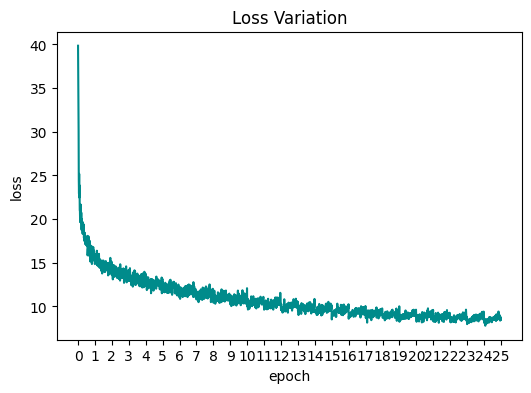

In [49]:
LEARNING_RATE = 0.005

#initialize the autocompleteModel
bestmodel = autocompleteModel(alphabet_size=27, embed_dim=32, hidden_size=128, num_layers=1)

#train the model
bestmodel.trainModel(vocab, epochs = 25, batch_size = 100)

### **Evaluate the model for different inputs**

In [66]:
sample_1 = ['univ', 'math', 'neur', 'engin']
completed_list_1 = bestmodel.autocomplete(sample_1)
print(f'Input : {sample_1}')
print(f'Output : {completed_list_1}')

Input : ['univ', 'math', 'neur', 'engin']
Output : ['universe_____', 'mathematic___', 'neuration____', 'engines______']


In [63]:
sample_2 = ['flow', 'fath', 'wall', 'hac', 'run', 'hun', 'drin', 'co', 'ver'] 
completed_list_2 = bestmodel.autocomplete(sample_2)
print(f'Input : {sample_2}')
print(f'Output : {completed_list_2}')

Input : ['flow', 'fath', 'wall', 'hac', 'run', 'hun', 'drin', 'co', 'ver']
Output : ['flower_______', 'father_______', 'walla________', 'hack_________', 'runks________', 'hunks________', 'drink________', 'commut_______', 'verify_______']


In [61]:
sample_3 = ['hou', 'sno', 'tem', 'beg', 'lau', 'kne', 'stru', 'inter']
completed_list_3 = bestmodel.autocomplete(sample_3)
print(f'Input : {sample_3}')
print(f'Output : {completed_list_3}')

Input : ['hou', 'sno', 'tem', 'beg', 'lau', 'kne', 'stru', 'inter']
Output : ['house________', 'snouth_______', 'temporary____', 'beginning____', 'laury________', 'knew_________', 'struggle_____', 'interpreted__']


In [75]:
sample_3 = ['hou', 'sno', 'tem', 'beg', 'lau', 'kne', 'stru', 'inter']
completed_list_3 = bestmodel.autocomplete(sample_3)
print(f'Input : {sample_3}')
print(f'Output : {completed_list_3}')

Input : ['hou', 'sno', 'tem', 'beg', 'lau', 'kne', 'stru', 'inter']
Output : ['hout_________', 'snood________', 'temple_______', 'began________', 'launches_____', 'knees________', 'structives___', 'intermediate_']


In [85]:
sample_4 = ['me', 'fea', 'wri', 'pa', 'app', 'kni', 'fut', 'barr']
completed_list_4 = bestmodel.autocomplete(sample_4)
print(f'Input : {sample_4}')
print(f'Output : {completed_list_4}')

Input : ['me', 'fea', 'wri', 'pa', 'app', 'kni', 'fut', 'barr']
Output : ['mega_________', 'fears________', 'writes_______', 'packages_____', 'appromissing_', 'knit_________', 'futtrieved___', 'barriers_____']
